In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
from scipy.io import wavfile
import os
from matplotlib.pyplot import *

def get_bouts(vox_times, ivi_thresh = 2, bout_length_thresh = 5):
    """
    Parameters: vox_times: ndarray
                        Array of vocalization onset times (s) since the start of the recording.
                ivi_thresh: int
                        Threshold for inter-vocalization-interval in seconds.
                bout_length_thresh: int
                        Threshold for number of vocalizations per bout.
    Returns:    bouts: Nx2 np.array
                        Bout onset (column 1)/offset (columns 2) indicies of vox_times, filtered by ISI and bout length.
                
    """
    #inter-vocalization-interval: how many seconds before me was a vocalization?
    ivi = np.insert(np.diff(vox_times), 0, 0) # add a 0 at the beginning to account for the array shortening
    
    #get onsets and offsets times (s) of vocalization bouts with IVIs < ivi_thresh
    onsets = np.where(np.insert(np.diff((ivi < ivi_thresh).astype('int')), 0, 1) == 1)[0]
    offsets = np.where(np.insert(np.diff((ivi < ivi_thresh).astype('int')), 0, 1) == -1)[0]-1
    onsets = onsets[:len(offsets)] #match onset/offset sizes
    
    #inclusive of t-1 and vocalizations in sequence
    bout_onsets = onsets[np.where(offsets-onsets > bout_length_thresh)[0]] - 1 
    bout_offsets = offsets[np.where(offsets-onsets > bout_length_thresh)[0]]
    
    bouts = np.array([bout_onsets, bout_offsets]).T
    
    return bouts

%matplotlib inline

In [11]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
df = pd.read_feather('vocalization_df.feather')

df_c2 = df[df.cohort == 'c2']
df_c4 = df[df.cohort == 'c4']
df_c5 = df[df.cohort == 'c5']

In [4]:
#get bouts
bouts_c2 = get_bouts(df_c2.dt_start, ivi_thresh=2, bout_length_thresh=5)
bouts_c4 = get_bouts(df_c4.dt_start, ivi_thresh=2, bout_length_thresh=5)
bouts_c5 = get_bouts(df_c5.dt_start, ivi_thresh=2, bout_length_thresh=5)

#get bout durations
bout_durs_c2 = np.array([df_c2.offset.iloc[bouts_c2[i][1]]-df_c2.onset.iloc[bouts_c2[i][0]] for i in range(len(bouts_c2))])
bout_durs_c4 = np.array([df_c4.offset.iloc[bouts_c4[i][1]]-df_c4.onset.iloc[bouts_c4[i][0]] for i in range(len(bouts_c4))])
bout_durs_c5 = np.array([df_c5.offset.iloc[bouts_c5[i][1]]-df_c5.onset.iloc[bouts_c5[i][0]] for i in range(len(bouts_c5))])

#find bouts that are about 4s
_4s_bouts_c2 = np.where((bout_durs_c2 > 3.9) * (bout_durs_c2 < 4.1))[0]
_4s_bouts_c4 = np.where((bout_durs_c4 > 3.9) * (bout_durs_c4 < 4.1))[0]
bouts_c2_4s = bouts_c2[_4s_bouts_c2]
bouts_c4_4s = bouts_c4[_4s_bouts_c4]

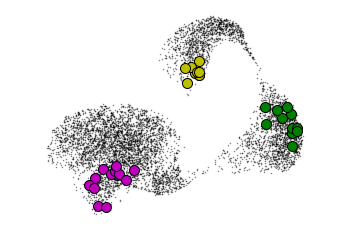

In [6]:
#pick examples from 4s bouts
bout1_umap = np.vstack(df_c2.latent_mean_umap.iloc[bouts_c2_4s[12][0]:bouts_c2_4s[12][-1]])
bout2_umap = np.vstack(df_c2.latent_mean_umap.iloc[bouts_c2_4s[-54][0]:bouts_c2_4s[-54][-1]])
bout3_umap = np.vstack(df_c4.latent_mean_umap.iloc[bouts_c4_4s[62][0]:bouts_c4_4s[62][-1]])

plot(np.vstack(df_c2.latent_mean_umap)[::25,0],
     np.vstack(df_c2.latent_mean_umap)[::25,1], '.k', markersize=1, alpha=0.5)

_markersize=20
plot(bout1_umap[:,0], bout1_umap[:,1], 'm.',markeredgecolor='k',
     markeredgewidth=1, markersize=_markersize)
plot(bout2_umap[:,0], bout2_umap[:,1], 'g.',markeredgecolor='k',
     markeredgewidth=1, markersize=_markersize)
plot(bout3_umap[:,0], bout3_umap[:,1], 'y.',markeredgecolor='k',
     markeredgewidth=1, markersize=_markersize)

axis('equal')
axis('off');

# spectrogram examples 

In [12]:
audio_basename = 'cohort2_combined_audio'

#bout1
audio_basename = 'cohort2_combined_audio'
audio_filename = "2020_07_20_15_29_37_785571_merged.wav"
onset, offset = 1000.48896, 1004.07296

#bout2
# audio_basename = 'cohort2_combined_audio'
# audio_filename = "2020_07_30_00_34_28_393297_merged.wav"
# onset, offset = 543.29344, 546.84877

#bout3
# audio_basename = 'cohort4_combined_audio'
# audio_filename = "2020_09_23_18_02_45_235282_merged.wav"
# onset, offset = 2027.58349, 2031.29037

fs, audio = wavfile.read(os.path.join(audio_basename, audio_filename))
working_audio = audio[int(onset*fs):int(offset*fs)]

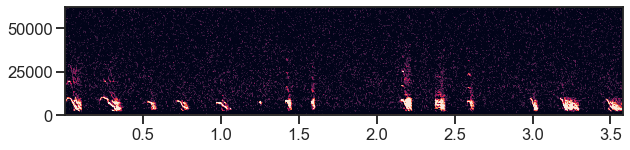

In [13]:
figure(figsize=(10,2))
specgram(working_audio, NFFT=512, noverlap=256, Fs=fs, clim=(-100, -85));